# Laboratorio 3: Clasificación



Integrantes: **Vicente Leyton C. - Andrés Salazar C.** y la sección de cada integrante

## Declaración de compromiso ético

Nosotros/as **Vicente Leyton C. - Andrés Salazar C.**, declaramos que realizamos de manera grupal los pasos de la presente actividad. También declaramos no incurrir en copia, ni compartir nuestras respuestas con otras personas ni con otros grupos. Por lo que, ratificamos que las respuestas son de nuestra propia confección y reflejan nuestro propio conocimiento.

## Instrucciones

1. Trabajen en equipos de dos personas.

2. Modifique este archivo `.ipynb` agregando sus respuestas donde corresponda.

3. El formato de entrega para esta actividad es un archivo **html**. Genere un archivo HTML usando jupyter y súbalo a U-Cursos. Basta con que **uno de los integrantes haga la entrega**. Si ambos hacen una entrega en U-Cursos, se revisará cualquiera de éstas.


A continuación vamos a cargar un dataset con noticias, el cual se puede encontrar en: https://www.kaggle.com/datasets/kevinmorgado/spanish-news-classification.

Los atributos que posee son:

- URL : El link a la noticia
- News: El texto de la noticia
- Type: La clasificación de la noticia


Para el laboratoria solo nos importan las columnas News y Type.


In [3]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/mzambrano1/Datasets-CC5205-otono-2023/master/lab2.1/noticias.csv")
df = df[["news", "Type"]]
df = df.rename(columns={
    'news': 'Noticia', 'Type':'Clasificación'})
df.head()


,Noticia,Clasificación
0,Durante el foro La banca articulador empresari...,Otra
1,El regulador de valores de China dijo el domin...,Regulaciones
2,En una industria históricamente masculina como...,Alianzas
3,Con el dato de marzo el IPC interanual encaden...,Macroeconomia
4,Ayer en Cartagena se dio inicio a la versión n...,Otra


A continuación preprocesaremos los textos y los convertiremos en vectores. Esto con el propósito de tener información numérica que pueda ser interpretable por los modelos que crearemos después.


In [5]:
import requests
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

def remove_numbers(text):
    text = re.sub(r"[0-9]", " ", text)
    return " ".join(text.split())

def remove_unprintable_(text):
    printable = set(string.printable + "ñáéíóúü" + "ÑÁÉÍÓÚÜ")
    text = "".join(filter(lambda x: x in printable, text))
    return text

def remove_punctuation(text):
    pattern = re.compile(r"[^\w\sáéíóúüñÁÉÍÓÚÜÑ]")
    t = pattern.sub(r" ", text)
    return re.sub(" +", " ", t)

def reduce_spam(text):
    text = re.sub(r"(\w+)(\s+\1){2,}", r"\1", text)
    text = re.sub(r"(\w+\s+\w+)(\s+\1){2,}", r"\1", text)
    return text

def remove_vowels_accents(text):
    return (
        text.replace("á", "a")
        .replace("é", "e")
        .replace("í", "i")
        .replace("ó", "o")
        .replace("ú", "u")
        .replace("ü", "u")
    )

def remove_stopwords(text, stopwords_list):
    return " ".join(
        [word for word in str(text).split() if word not in stopwords_list]
    )

url = "https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt"
r = requests.get(url)

stopwords_list = r.text.splitlines()

def preprocesar(text):
    text = text.lower()
    text = remove_numbers(text)
    text = remove_unprintable_(text)
    text = remove_punctuation(text)
    text = reduce_spam(text)
    text = remove_stopwords(text, stopwords_list)
    text = remove_vowels_accents(text)
    return text.strip()


# Extraer los vectores
vectorizer = CountVectorizer(preprocessor=preprocesar, min_df=2)
vectors = vectorizer.fit_transform(df["Noticia"])

# Incorporar los vectores como dataframe
X = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
y = df["Clasificación"]

df_vectorizado = pd.concat([y, X], axis=1)
df_vectorizado.head()


,Clasificación,aa,aaa,abacum,abajo,abandonar,abandono,abanico,abaratamiento,abaratar,...,zero,zhao,zijin,zmvm,zona,zonas,zuckerberg,zug,zuluaga,zurich
0,Otra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Regulaciones,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alianzas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Macroeconomia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Otra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pregunta 1

Cargue los datos e indique lo siguiente:

- Tamaño del dataset vectorizado (cantidad de instancias y atributos).
- ¿Cuántas clases hay en la columna "Clasificación" y cuáles son sus nombres?
- ¿Cuántas instancias hay en cada clase?

Indique en cada caso cómo obtuvo la respuesta, es decir, adjunte código.


In [6]:
df_vectorizado.shape

(1217, 14407)

In [7]:
df_vectorizado['Clasificación'].unique()

array(['Otra', 'Regulaciones', 'Alianzas', 'Macroeconomia', 'Innovacion',
       'Sostenibilidad', 'Reputacion'], dtype=object)

Hay 7 clases distintas: 'Otra', 'Regulaciones', 'Alianzas', 'Macroeconomia', 'Innovacion' y 'Sostenibilidad'

In [8]:
df_vectorizado.value_counts('Clasificación')

Clasificación
Macroeconomia     340
Alianzas          247
Innovacion        195
Regulaciones      142
Sostenibilidad    137
Otra              130
Reputacion         26
Name: count, dtype: int64

### Pregunta 2


En esta parte useremos el clasificador **Naive Bayes**. Veremos distintas formas de usarlo, y vamos a compararlas utilizando diversas métricas.


Usando el siguiente código, entrenaremos un clasificador con los datos cargados (X, y) y haremos una predicción sobre los mismos datos empleando dicho clasificador entrenado. Luego, se mostrarán las métricas de **accuracy**, **precision**, **recall** y **f1-score**.


In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

clf = GaussianNB()
clf.fit(X, y)
y_pred = clf.predict(X)

print(classification_report(y, y_pred))

                precision    recall  f1-score   support

      Alianzas       1.00      0.99      0.99       247
    Innovacion       1.00      1.00      1.00       195
 Macroeconomia       1.00      0.99      1.00       340
          Otra       0.98      1.00      0.99       130
  Regulaciones       0.99      1.00      1.00       142
    Reputacion       0.87      1.00      0.93        26
Sostenibilidad       1.00      0.99      1.00       137

      accuracy                           0.99      1217
     macro avg       0.98      1.00      0.99      1217
  weighted avg       0.99      0.99      0.99      1217



De acuerdo a los resultados obtenidos:

- ¿Qué opina sobre las predicciones?
- ¿Qué problema puede identificar?


Son buenas predicciones pero porque se trabajan con los mismos datos con los cuales lo entrenamos, siendo este el problema del modelo. Al hacer esto, hacemos overfitting.

**Respuesta:**



### Pregunta 3


Ahora lo que haremos será dividir nuestro dataset en 70% entrenar (**_training set_**) y 30% para testear (**_testing set_**). Use la función **_train_test_split()_** de _sklearn_ y utilice las variables `X_train, X_test, y_train, y_test`.


Escriba el código necesario para dividir los datos, entrenar el modelo e indicar el **accuracy**, **precision** y **recall** del clasificador.

Entrene usando el **_training set_** y pruebe sobre el **_testing set_**, en base a la división 70%-30%, respectivamente

**NOTA: para dividir el dataset use el parámetro `stratify=y`.**


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=37, stratify=y)

In [13]:
clf_2 = GaussianNB()
clf_2.fit(X_train, y_train)
y_pred = clf_2.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      Alianzas       0.70      0.72      0.71        74
    Innovacion       0.73      0.88      0.80        59
 Macroeconomia       0.79      0.95      0.86       102
          Otra       0.76      0.33      0.46        39
  Regulaciones       0.84      0.60      0.70        43
    Reputacion       0.33      0.12      0.18         8
Sostenibilidad       0.76      0.83      0.79        41

      accuracy                           0.75       366
     macro avg       0.70      0.63      0.64       366
  weighted avg       0.75      0.75      0.74       366



¿Qué opina sobre las predicciones obtenidas en la pregunta anterior?

Responda lo siguiente:

- Comparando los clasificadores de las preguntas 2 y 3 ¿Cuál tiene peores resultados? ¿Por qué?
- ¿Cuál de las dos formas de entrenar el clasificador prefiere? Justifique su respuesta


El modelo de la pregunta 3 tiene peores resultados porque los datos que ocupa para entrenar no son los mismos que ocupa para testear. Por lo que al ser tan escasa la cantidad de datos, el modelo no aprende lo suficiente para poder clasificar de manera correcta. 

De todas maneras, se prefiere utilizar la segunda forma de entrenar el clasficador (la de la pregunta 3) porque no realizamos el overfitting de la Pregunta 2 y no generamos métricas de evaluación poco confiables.

**Respuesta:**


### Pregunta 4

Grafique una matriz de confusión para los resultados de clasificación de la pregunta anterior. Interprete la matriz y comente sobre cada uno de los valores distintos de 0 en la matriz y describa lo que representa.

_Verifique que los resultados que se imprimen concuerden con su respuesta._


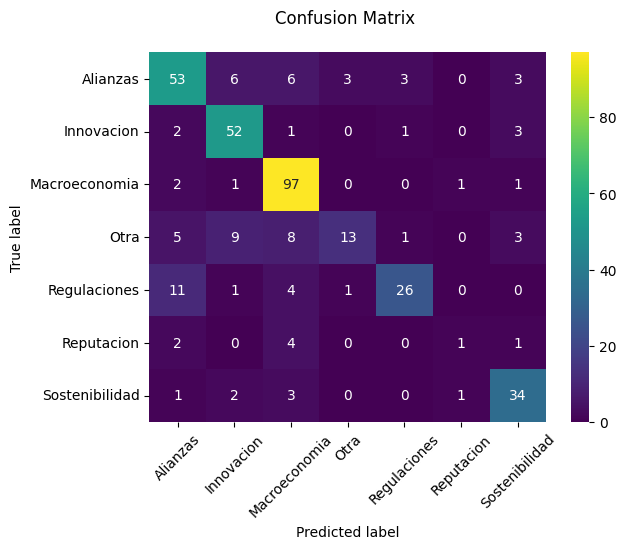

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

classes = unique_labels(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()

ax = sns.heatmap(cm, annot=True, cmap="viridis")

ax.set_yticklabels(classes, rotation=0)
ax.set_xticklabels(classes, rotation=45)

ax.set_title('Confusion Matrix \n')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.show()

**Respuesta:** Los valores distintos de cero y fuera de la diagonal, representan los casos donde el modelo falló en la clasificación. Siendo 'Reputación' la clase con menor exactitud en la predicción, lo que concuerda con lo visto anteriormente en las métricas de evaluaciones de la pregunta 3.



### Pregunta 5

Para este clasificador utilizaremos Cross-validation. Con cross-validation, el conjunto de entrenamiento se divide en $k$ conjuntos disjuntos; se entrena sobre los datos correspondientes a $k-1$ de éstos, y se evalúa sobre el conjunto restante. Esto se repite $k$ veces, evaluando siempre sobre un conjunto distinto. Teniendo en cuenta el parámetro $k$, a éste método se le llama $k$-fold cross-validation. Una forma de estimar el rendimiento del clasificador es, entre otras cosas, calculando el promedio de todos los k-folds.

Escriba un código que ejecute 10-fold cross-validation usando Naive Bayes sobre los datos, evaluando las métricas: 'precision_macro', 'recall_macro', 'accuracy', 'f1_macro'.


In [21]:
from sklearn.model_selection import cross_validate
import numpy as np

scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

cv_results = cross_validate(clf, X, y, cv=10, scoring=scoring)


c:\Users\vicen\OneDrive - Universidad de Chile\Universidad\7mo Semestre\Minería de Datos\Laboratorios\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'test_accuracy', 'test_f1_macro'])

In [23]:
cv_results['test_accuracy']

array([0.73770492, 0.74590164, 0.6557377 , 0.70491803, 0.71311475,
       0.74590164, 0.72131148, 0.74380165, 0.74380165, 0.76859504])

In [24]:
print('Promedio Precision:', np.mean(cv_results['test_precision_macro']))
print('Promedio Recall:   ', np.mean(cv_results['test_recall_macro']))
print('Promedio F1-score: ', np.mean(cv_results['test_f1_macro']))
print('Promedio Accucary: ', np.mean(cv_results['test_accuracy']))

Promedio Precision: 0.6959131981785224
Promedio Recall:    0.6278711168677997
Promedio F1-score:  0.6379147434690408
Promedio Accucary:  0.7280788511041865


- Compare los valores de las métricas con respecto a lo obtenido en la pregunta 3. Comente en qué difieren y por qué.
- ¿Qué beneficios tiene emplear cross-validation?



**Respuesta:**


### Pregunta 6

Entrene otro clasificador distinto de Naive Bayes a su elección y evalue sus resultados de la forma que estime conveniente. Luego responda las siguentes preguntas:

- ¿En qué se diferencian ambos clasificadores? Considere tanto los resultados como los propios algoritmos
- ¿Cuál de los dos clasificadores le parece que es la mejor opción? Justifique su respuesta



In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kn_clf = KNeighborsClassifier(n_neighbors=5)

kn_clf.fit(X_train, y_train)

y_pred = kn_clf.predict(X_test)

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

      Alianzas       0.58      0.20      0.30        74
    Innovacion       0.62      0.71      0.66        59
 Macroeconomia       0.41      0.98      0.58       102
          Otra       0.73      0.28      0.41        39
  Regulaciones       1.00      0.07      0.13        43
    Reputacion       0.00      0.00      0.00         8
Sostenibilidad       0.82      0.22      0.35        41

      accuracy                           0.49       366
     macro avg       0.59      0.35      0.35       366
  weighted avg       0.62      0.49      0.43       366



c:\Users\vicen\OneDrive - Universidad de Chile\Universidad\7mo Semestre\Minería de Datos\Laboratorios\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicen\OneDrive - Universidad de Chile\Universidad\7mo Semestre\Minería de Datos\Laboratorios\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicen\OneDrive - Universidad de Chile\Universidad\7mo Semestre\Minería de Datos\Laboratorios\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precis

**Respuesta:**

### Pregunta 7

Cuando hacemos clasificación en Data Mining queremos encontrar un patrón en los datos. Analice los atributos de los datos junto a los resultados obtenidos en la pregunta anteriores y describa sus principales observaciones. ¿Cómo se relacionan los atributos X con la clase de interés y? Es una pregunta abierta, puede apoyar su análisis con tablas y/o visualizaciones.